### Importação das bibliotecas

Importamos as bibliotecas necessárias

In [2]:
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

1. Carregamento do dataset e separação entre variáveis independentes e alvo.

In [ ]:
df = pd.read_csv("ocorrencias_aereas_tratadas.csv", encoding='latin1')

X = df.drop(columns=[
    'codigo_ocorrencia', 'ocorrencia_classificacao',
    'outlier_ocorrencia_longitude','outlier_ocorrencia_latitude',
    'outlier_aeronave_pmd','outlier_aeronave_assentos',
    'cluster'
])
y = df['ocorrencia_classificacao']


2. Identificando tipos de colunas

In [ ]:
colunas_numericas = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
colunas_categoricas = X.select_dtypes(include='object').columns.tolist()

print(f"Colunas numéricas: {colunas_numericas}")
print(f"Colunas categóricas: {colunas_categoricas}")

Colunas numéricas: ['ocorrencia_latitude', 'ocorrencia_longitude', 'aeronave_pmd', 'aeronave_assentos', 'aeronave_ano_fabricacao', 'ocorrencia_ano', 'aeronave_idade']
Colunas categóricas: ['ocorrencia_cidade', 'ocorrencia_uf', 'ocorrencia_pais', 'ocorrencia_aerodromo', 'ocorrencia_dia', 'ocorrencia_hora', 'aeronave_matricula', 'aeronave_operador_categoria', 'aeronave_tipo_veiculo', 'aeronave_fabricante', 'aeronave_modelo', 'aeronave_tipo_icao', 'aeronave_motor_tipo', 'aeronave_motor_quantidade', 'aeronave_pmd_categoria', 'aeronave_pais_fabricante', 'aeronave_pais_registro', 'aeronave_registro_categoria', 'aeronave_registro_segmento', 'aeronave_voo_origem', 'aeronave_voo_destino', 'aeronave_tipo_operacao', 'outlier_aeronave_ano_fabricacao']


3. Definindo transformador

In [ ]:
preprocessador = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), colunas_categoricas)
], remainder='passthrough')  # Mantém numéricas como estão

4. Criando o pipeline com Random Forest e SMOTE

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('smote', SMOTE(k_neighbors=1,random_state=42)),
    ('classificador', RandomForestClassifier(max_depth=15, min_samples_leaf=5, random_state=42))
])

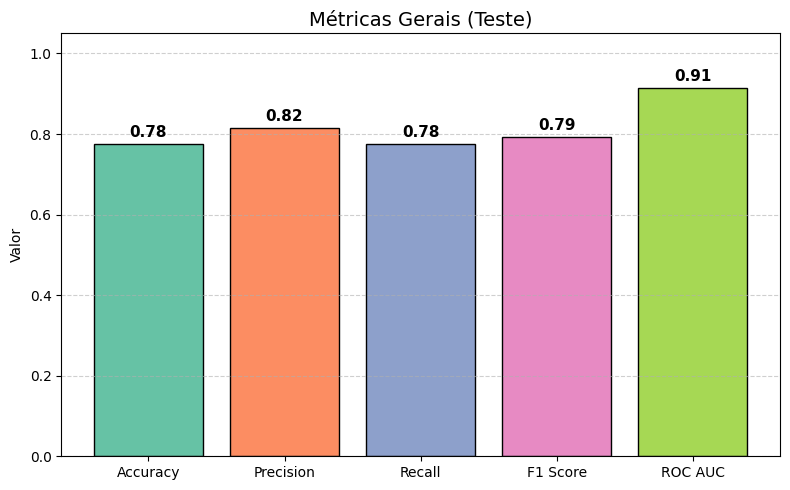

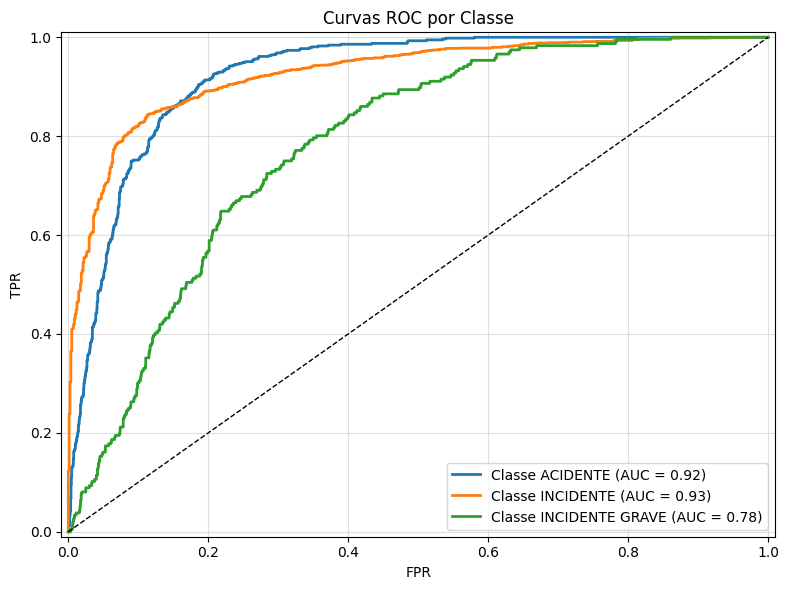


=== CROSS VALIDATION (5-fold) ===


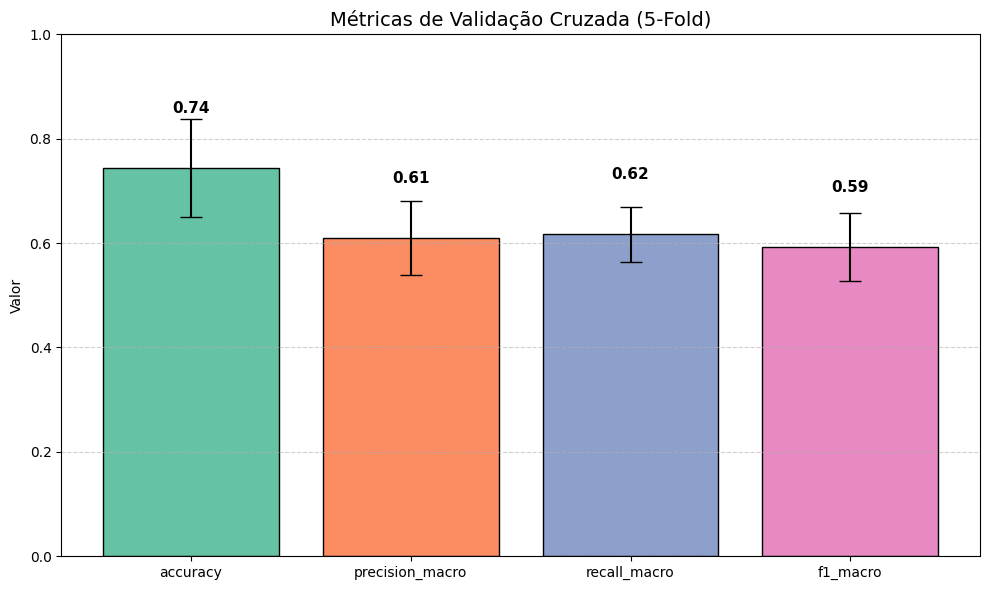

In [7]:
# 5. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 6. Treinar modelo
pipeline.fit(X_train, y_train)
# Previsões
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Binariza as classes para cálculo da curva ROC AUC
classes = pipeline.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_proba_bin = y_proba

# Calcular ROC AUC
try:
    roc_auc = roc_auc_score(y_test_bin, y_proba_bin, average='weighted', multi_class='ovr')
except:
    roc_auc = None

# ==== GRÁFICO DAS MÉTRICAS GERAIS ====
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score'] + (['ROC AUC'] if roc_auc is not None else [])
metric_values = [acc, prec, rec, f1] + ([roc_auc] if roc_auc is not None else [])
colors = sns.color_palette('Set2', n_colors=len(metric_values))

plt.figure(figsize=(8, 5))
bars = plt.bar(metric_labels, metric_values, color=colors, edgecolor='black')

# Adiciona os valores nas barras
for bar, value in zip(bars, metric_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylim(0, 1.05)
plt.ylabel("Valor")
plt.title("Métricas Gerais (Teste)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ==== CURVAS ROC AUC (Multiclasse) ====
if roc_auc is not None:
    plt.figure(figsize=(8, 6))
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_bin[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Classe {class_label} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Curvas ROC por Classe')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()
else:
    print("ROC AUC não pôde ser calculado.")
# 9. Cross-validation
print("\n=== CROSS VALIDATION (5-fold) ===")
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Validação cruzada
resultados = cross_validate(pipeline, X, y, cv=5, scoring=scoring, return_train_score=True)

# Substitua pelos dados reais do seu cross_validate
metrics = {
    'accuracy': resultados['test_accuracy'],
    'precision_macro': resultados['test_precision_macro'],
    'recall_macro': resultados['test_recall_macro'],
    'f1_macro': resultados['test_f1_macro']
}

# Cálculo das médias e desvios padrão
labels = list(metrics.keys())
values = [np.mean(metrics[m]) for m in labels]
errors = [np.std(metrics[m]) for m in labels]

# Cores bonitas
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']  # paleta Set2

# Gráfico de barras com matplotlib
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, yerr=errors, capsize=8, color=colors, edgecolor='black')

# Adiciona os valores acima das barras
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1,
             f'{value:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Estilo do gráfico
plt.ylim(0, 1)
plt.ylabel("Valor")
plt.title("Métricas de Validação Cruzada (5-Fold)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()